written by Charlie Moffett, NYU CUSP, 2017

In [4]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as pl
%pylab inline

import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

Populating the interactive namespace from numpy and matplotlib


__An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easily observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.__

## So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [6]:
# Either obtain the data through the API or download the csv file, and move it to $PUIDATA
# The next line will download the 'Energy-and-Water-Data-Disclosure-for-Local-Law-84' data locally
# !wget https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv

--2017-10-23 17:37:35--  https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
Resolving data.cityofnewyork.us... 52.206.140.199
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4433512 (4.2M) [text/csv]
Saving to: “rows.csv”

100%[======================================>] 4,433,512   18.1M/s   in 0.2s    

Last-modified header invalid -- time-stamp ignored.
2017-10-23 17:37:35 (18.1 MB/s) - “rows.csv” saved [4433512/4433512]



In [7]:
# Looking in PUIDATA to show that the file is not there yet
# !ls $PUIDATA

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv
API_SP.POP.TOTL_DS2_en_csv_v2.csv
BORO_zip_files_csv
data-pvLFI.csv
World firearms murders and ownership - Sheet 1.csv


In [8]:
# Moving the dataset 'rows.csv', which is the 'Energy-and-Water-Data-Disclosure-for-Local-Law-84',
# into PUIDATA
# os.system("mv %s %s"%("rows.csv", os.getenv("PUIDATA")))

0

In [10]:
# Demonstrating that the dataset has been moved into PUIDATA
!ls $PUIDATA

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv
API_SP.POP.TOTL_DS2_en_csv_v2.csv
BORO_zip_files_csv
data-pvLFI.csv
rows.csv
World firearms murders and ownership - Sheet 1.csv


In [13]:
# creating a pandas dataframe from the dataset
nrg=pd.read_csv(os.getenv("PUIDATA")+'/rows.csv')
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# However this dataset does not have the number of units. We can find that in the Pluto dataset.
# !wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip

--2017-10-23 17:53:25--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip
Resolving www1.nyc.gov... 23.66.229.194, 2600:1400:a:1a3::1500, 2600:1400:a:18f::1500
Connecting to www1.nyc.gov|23.66.229.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9857321 (9.4M) [application/zip]
Saving to: “mn_mappluto_16v2.zip”

100%[======================================>] 9,857,321   32.5M/s   in 0.3s    

2017-10-23 17:53:26 (32.5 MB/s) - “mn_mappluto_16v2.zip” saved [9857321/9857321]



In [25]:
# !unzip -d $PUIDATA mn_mappluto_16v2.zip

Archive:  mn_mappluto_16v2.zip
  inflating: /home/cusp/cm4698/PUIdata/PLUTODD16v2.pdf  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.dbf  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.prj  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.sbn  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.sbx  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.shp  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.shp.xml  
  inflating: /home/cusp/cm4698/PUIdata/MN_Dcp_Mappinglot.shx  
  inflating: /home/cusp/cm4698/PUIdata/mn_pluto.dbf  
  inflating: /home/cusp/cm4698/PUIdata/mn_pluto.dbf.xml  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.BBL.atx  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.CD.atx  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.dbf  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.LandUse.atx  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.prj  
  inflating: /home/cusp/cm4698/PUIdata/MNMapPLUTO.sbn  
  in

In [20]:
# os.system("mv %s %s"%("mn_mappluto_16v2.zip", os.getenv("PUIDATA")))

0

In [26]:
!ls $PUIDATA

201501-citibike-tripdata.csv
201501-citibike-tripdata.zip
201503-citibike-tripdata.csv
201503-citibike-tripdata.zip
201507-citibike-tripdata.csv
201507-citibike-tripdata.zip
API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv
API_SP.POP.TOTL_DS2_en_csv_v2.csv
BORO_zip_files_csv
data-pvLFI.csv
MN_Dcp_Mappinglot.dbf
MN_Dcp_Mappinglot.prj
MN_Dcp_Mappinglot.sbn
MN_Dcp_Mappinglot.sbx
MN_Dcp_Mappinglot.shp
MN_Dcp_Mappinglot.shp.xml
MN_Dcp_Mappinglot.shx
mn_mappluto_16v2.zip
MNMapPLUTO.BBL.atx
MNMapPLUTO.CD.atx
MNMapPLUTO.dbf
MNMapPLUTO.LandUse.atx
MNMapPLUTO.prj
MNMapPLUTO.sbn
MNMapPLUTO.sbx
MNMapPLUTO.shp
MNMapPLUTO.shp.xml
MNMapPLUTO.shx
MNMapPLUTO.ZoneDist1.atx
mn_pluto.dbf
mn_pluto.dbf.xml
PLUTODD16v2.pdf
rows.csv
World firearms murders and ownership - Sheet 1.csv


In [27]:
# Confirms that the unzipped CSV is in PUIDATA, otherwise will download it for you
PUIdata=os.getenv("PUIDATA")
if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


In [28]:
# Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp
bsize=pd.read_csv(PUIdata + "/BORO_zip_files_csv/MN.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [30]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [31]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoo

In [32]:
# Clean up nrg data by throwing away columns I do not need
nrg_new=nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Primary Property Type - Self Selected',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],axis=1)

In [33]:
nrg_new.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
0,1.000410e+09,NaN,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,NaN,82730.0,1.0
2,2.027620e+09,NaN,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0
4,2.048300e+09,NaN,NaN,50000,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f014c9042b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0149c42550>]], dtype=object)

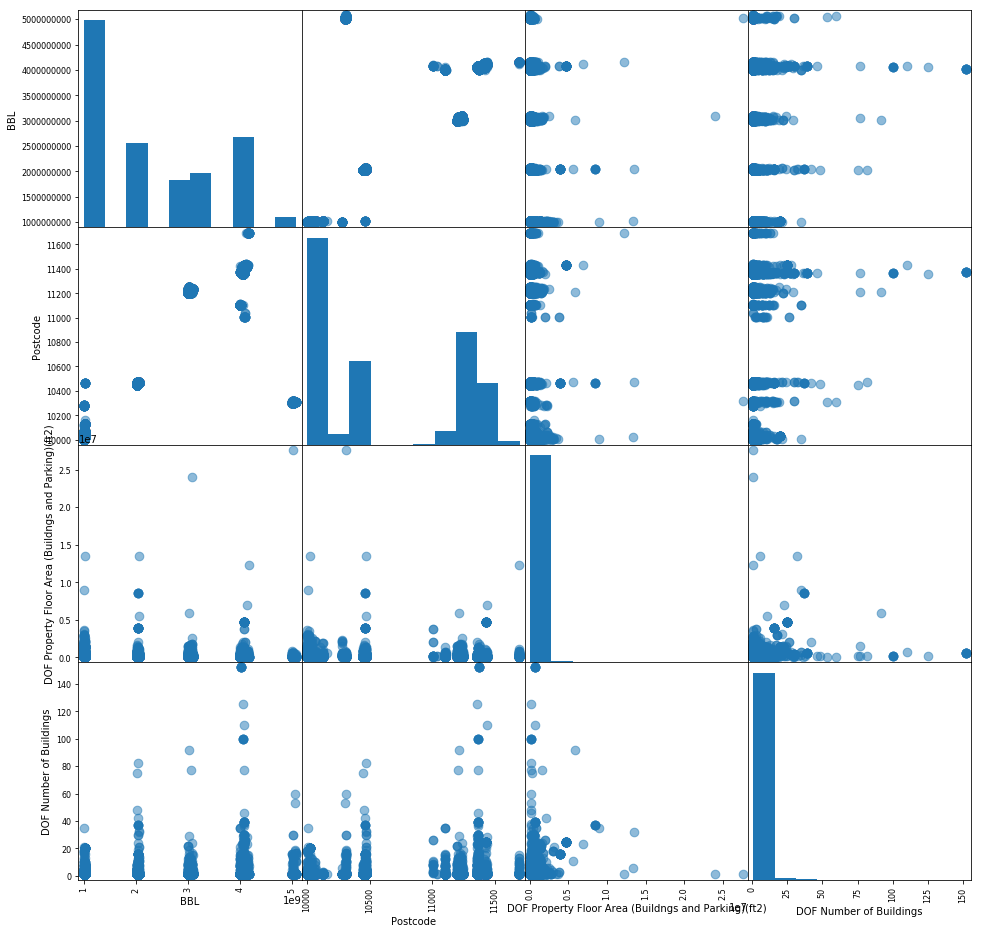

In [34]:
# Make a scatter plot of nrg_new
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_new, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

In [37]:
# Transforms values to float (when possible)
nrg_new['Site EUI(kBtu/ft2)']=pd.to_numeric(nrg_new['Site EUI(kBtu/ft2)'],errors='coerce')

In [38]:
nrg_new['BBL']=pd.to_numeric(nrg_new['BBL'],errors='coerce')

In [39]:
nrg_new['Reported Property Floor Area (Building(s)) (ft²)']=pd.to_numeric(
    nrg_new['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')

In [44]:
#How many missing values?
indx = np.isnan(nrg_new['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


In [40]:
#How many missing values?
indx = np.isnan(nrg_new['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print("Invalid entries changed to NaN: {}".format(indx))
#do it for however many columns you need

Invalid entries changed to NaN: 3125


In [71]:
##check that your conversion worked:
print(nrg_new['Site EUI(kBtu/ft2)'].dtype)

float64


In [72]:
bsize.BBL.dtype

dtype('float64')

In [35]:
# Clean up PLUTO data
bsize_new=bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version'],axis=1)

In [36]:
bsize_new.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1900,1.000010e+09
2,0,0,1900,1.000010e+09
3,0,0,0,1.000010e+09
4,0,0,0,1.000010e+09


# MERGE THE DATASETS

In [47]:
# Look at the syntax for pandas.merge
# pd.merge?

In [54]:
(bsize_new.BBL.values[0]), (nrg_new.BBL.values[0])

(1000010010.0, 1000410001.0)

In [61]:
mergedata=nrg_new.merge(bsize_new,on='BBL')

In [62]:
mergedata.dropna
mergedata.shape

(6536, 9)

In [63]:
mergedata.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0,0,1,1987
1,1.004370e+09,10009.0,NaN,NaN,52390.0,1.0,0,4,1920
2,1.013110e+09,10022.0,125.4,330000.0,313200.0,1.0,0,56,1977
3,1.009220e+09,10003.0,NaN,NaN,98260.0,1.0,148,148,1963
4,1.007400e+09,NaN,NaN,68329.0,NaN,NaN,0,1,1920


In [64]:
mergedata=mergedata.drop(['Postcode','DOF Number of Buildings'],axis=1)

mergedata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


In [65]:
mergedata.columns=['BBL','SiteEUI','AreaReported','DOFfloorArea','UnitsRes','UnitsTotal','YearBuilt']
mergedata.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01443c78d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f013e69c400>]], dtype=object)

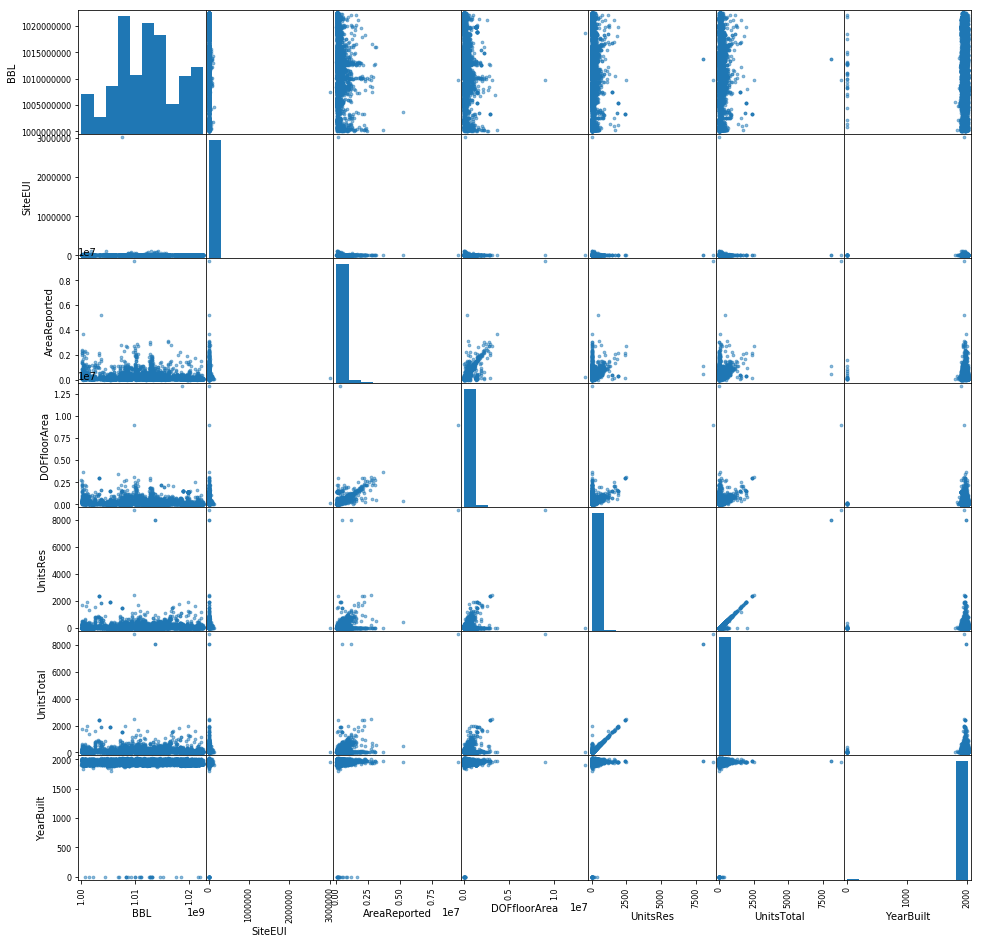

In [73]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (mergedata, s=30, figsize=(16, 16))

Figure 2: scatter matrix of merged dataset

Figure 2 does the same as Figure 1 but because I converted additional columns into float, pandas was able to plot the additional columns. The columns I am interested in are u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. These are the columns previously omitted, but now included. I can see now the correlation between all variables contained in my final dataset.

# Make a scatter plot first of Energy vs Units.

In [74]:
# Convert energy per sq ft into Energy TOTAL
mergedata['EnergyTOTAL']=mergedata.SiteEUI*mergedata.AreaReported

Text(0,0.5,'Number of Units')

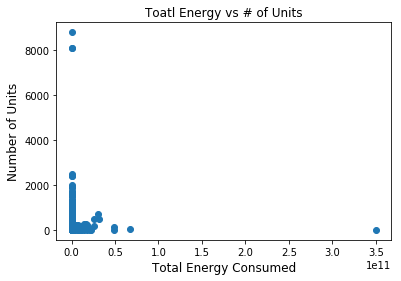

In [76]:
# Now plotting it
pl.scatter(mergedata.EnergyTOTAL,mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total # of Units')
pl.xlabel('Total Energy Consumed',fontsize=12)
pl.ylabel('Number of Units', fontsize=12)

Figure 3: Plots total energy consumption of each BBL vs the number of units in the building

It looks really bad because all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. So we have some outliers with very high numbers of units, and another outlier with a very high amount of total energy consumed (but low total number of units).

I chose Total Units instead of Residential Units because a number of the BBLs don't have any residential units, so in order to plot more points I went the Total Units route.

### Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted

(1, 1000)

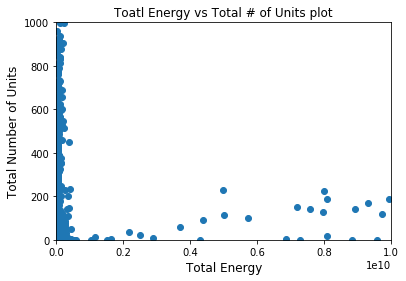

In [92]:
# zoomed in scatter plot
pl.scatter(mergedata.EnergyTOTAL, mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total # of Units plot')
pl.xlabel('Total Energy',fontsize=12)
pl.ylabel('Total Number of Units', fontsize=12)
pl.xlim(1000,1e10)
pl.ylim(1,1000)

Figure 4: same as Figure 3, but zooms into the region where most points are.

I accomplished this zooming in by cutting my x and y axes in the process of plotting them by using xlim=(1000,1e10), ylim=(1,1000).